In [28]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import soundfile as sf
from model import Diffusion,sample,p_losses
import torch
# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline
timesteps =1000 #diffusion timestep

In [25]:

filename_cargo_15 = r"DeepShip-main\Cargo\15.wav"
wav_cargo_15,sr = sf.read(filename_cargo_15)
filename_Passengership_1 = r"DeepShip-main\Passengership\1.wav"
wav_Passengership_1,sr = sf.read(filename_Passengership_1)
filename_Tanker_2 = r"DeepShip-main\Tanker\2.wav"
wav_Tanker_2,sr = sf.read(filename_Tanker_2)
filename_Tug_2 = r"DeepShip-main\Tug\9.wav"
wav_Tug_9,sr = sf.read(filename_Tug_2)

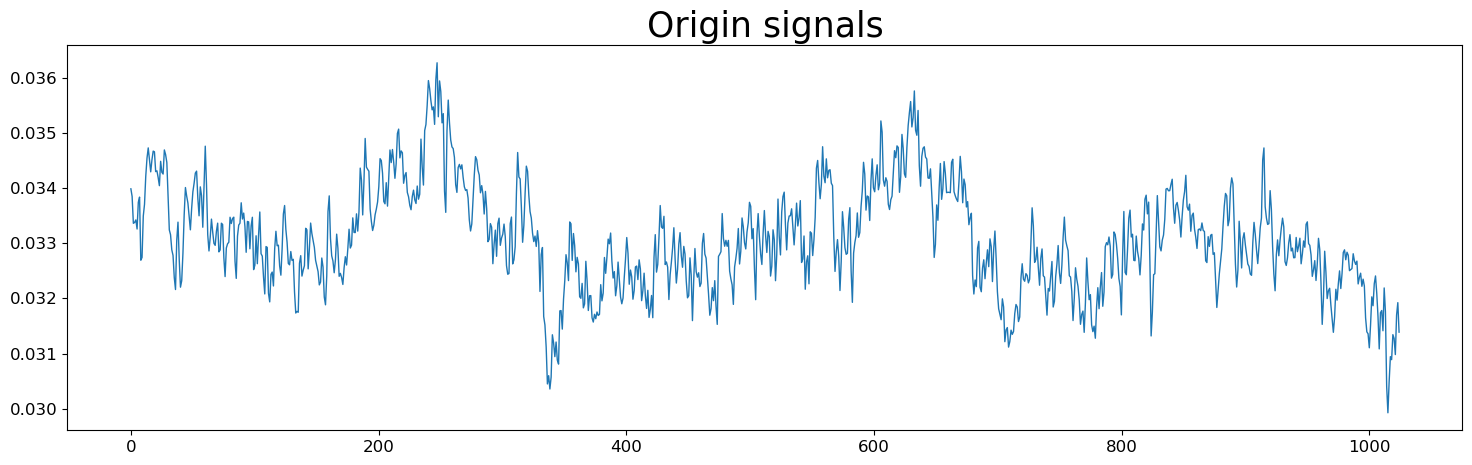

In [3]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(np.linspace(0, 1024,1024), wav_cargo_15[:1024], lw=1)
ax.set_title('Origin signals', fontsize=25)
ax.tick_params(labelsize=12)

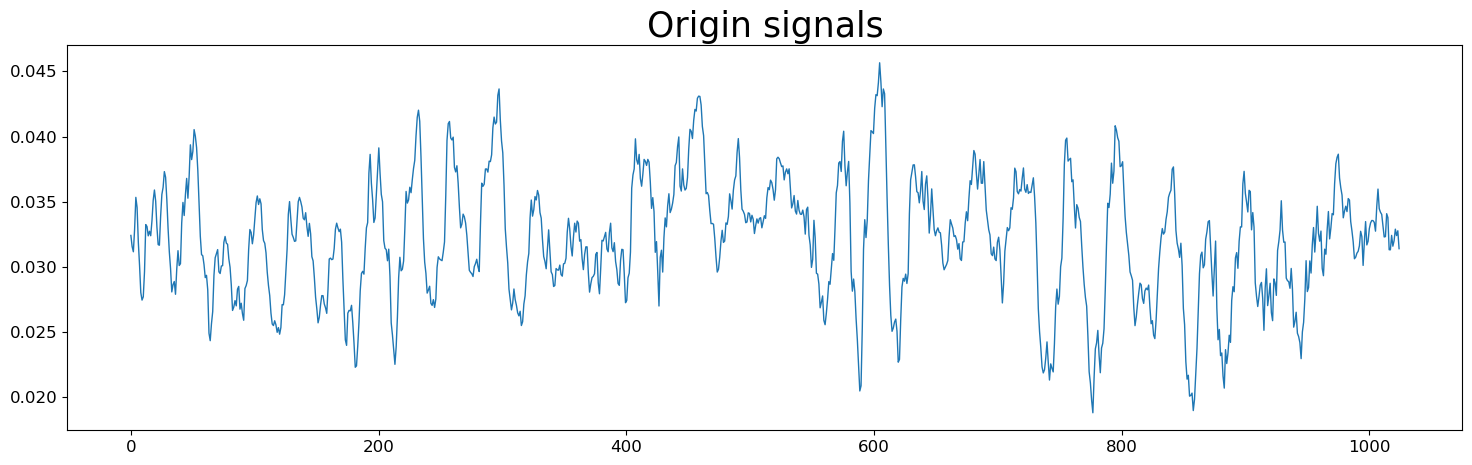

In [4]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(np.linspace(0, 1024,1024), wav_Passengership_1[:1024], lw=1)
ax.set_title('Origin signals', fontsize=25)
ax.tick_params(labelsize=12)

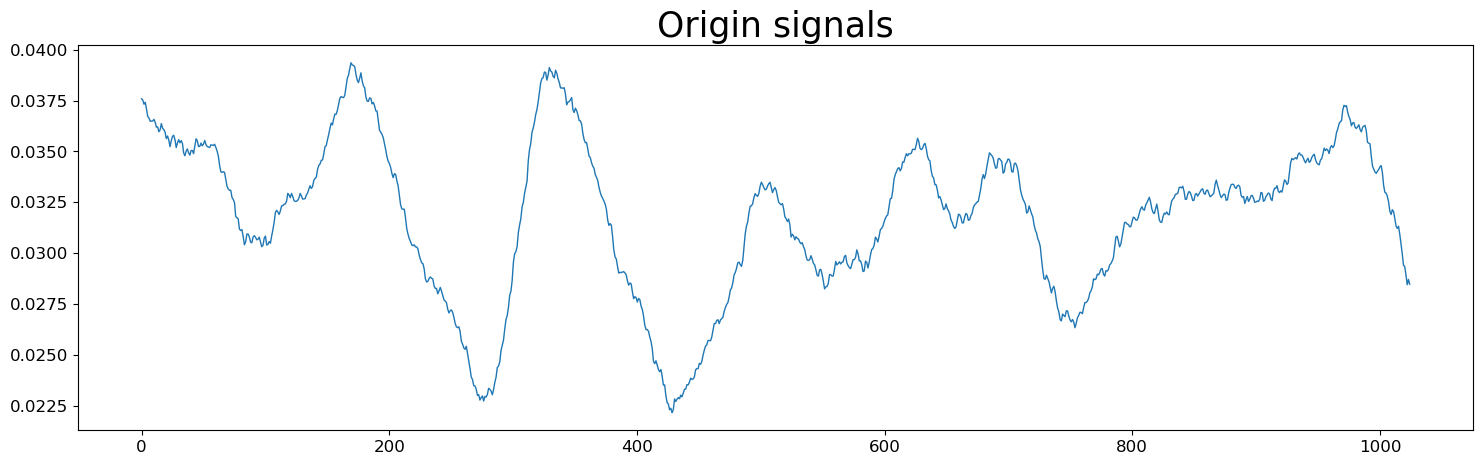

In [5]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(np.linspace(0, 1024,1024), wav_Tanker_2[:1024], lw=1)
ax.set_title('Origin signals', fontsize=25)
ax.tick_params(labelsize=12)

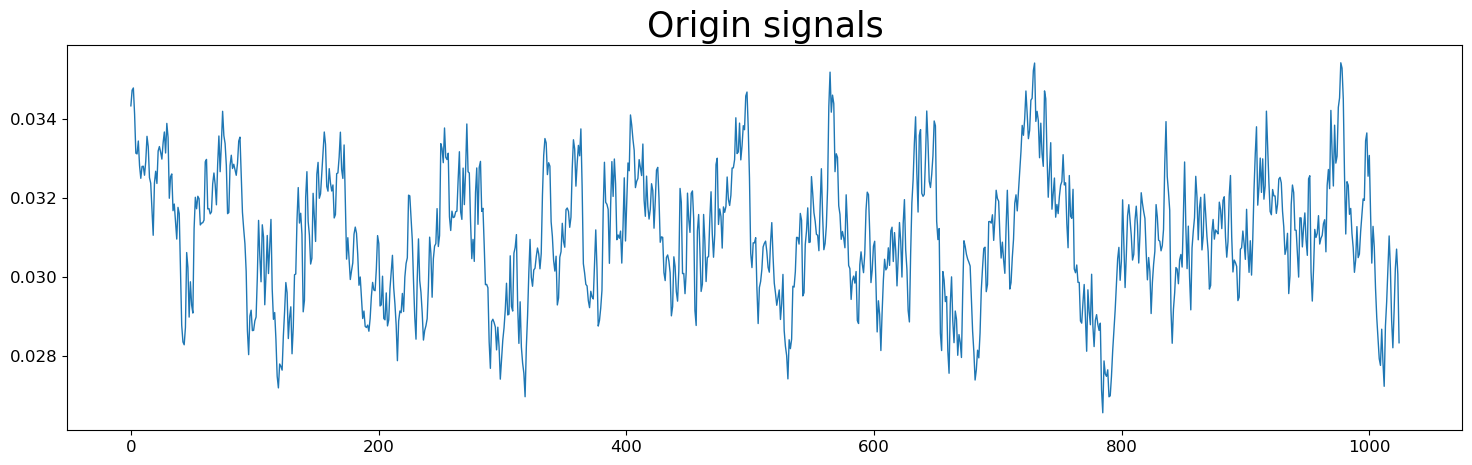

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(np.linspace(0, 1024,1024), wav_Tug_9[:1024], lw=1)
ax.set_title('Origin signals', fontsize=25)
ax.tick_params(labelsize=12)

In [12]:
model = Diffusion()
model.load_state_dict(torch.load('Signal10244_ship_diffusion_model_epoch_100000_dataset_1_sample_1000_time.pth'))
ns = np.linspace(0, 1024, 1024)
data_single =np.array([wav_cargo_15[:1024],wav_Passengership_1[:1024],wav_Tanker_2[:1024],wav_Tug_9[:1024]])

In [15]:
device = "cuda"
model=model.to(device)
samples = sample(model, image_size=1024, batch_size=1, channels=1)
last_sample = samples[-1]

torch.Size([1, 1, 1024])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

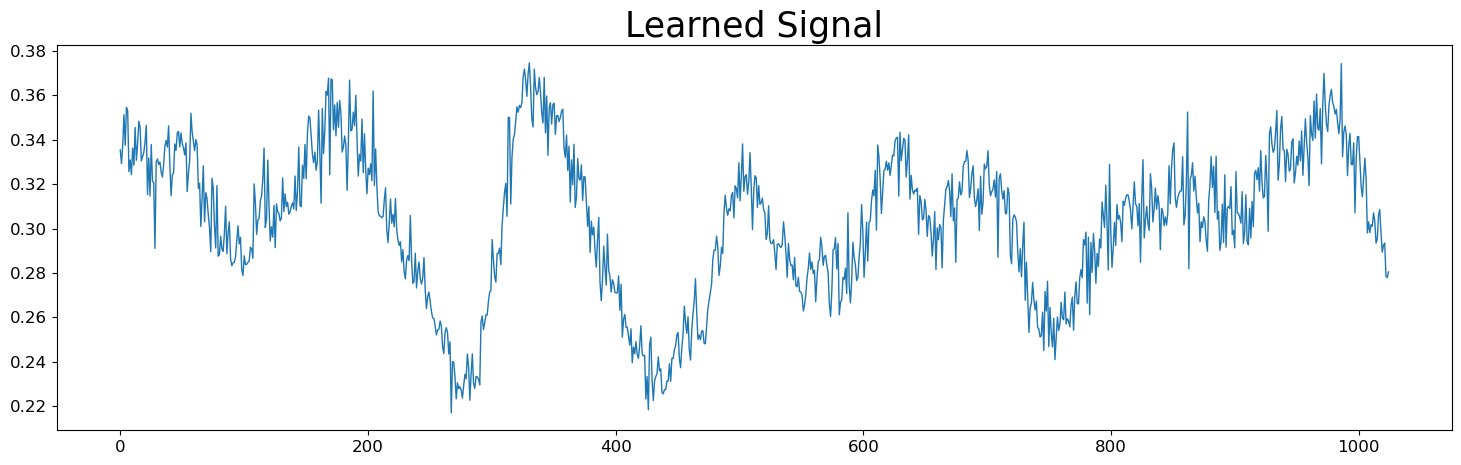

In [16]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],last_sample.cpu().detach().numpy()[0,0][:1024], lw=1)
ax.set_title('Learned Signal', fontsize=25)
ax.tick_params(labelsize=12)

In [17]:
random_matrix = np.random.rand(2,4)
inverse_random_matrix=np.linalg.pinv(random_matrix)

In [18]:
print(random_matrix)

[[0.63445972 0.41457325 0.36831624 0.82873411]
 [0.43545984 0.0633374  0.04995993 0.97835412]]


In [19]:
print(inverse_random_matrix)

[[ 0.72352359 -0.33241549]
 [ 1.23094477 -1.15300112]
 [ 1.11522818 -1.0510483 ]
 [-0.45867546  1.29839693]]


In [20]:
from torch import nn, einsum, optim
import torch
import tqdm
class generalized_inverse(nn.Module):
    def __init__(self):
        super().__init__()
        self.source2signal = torch.tensor(random_matrix, requires_grad=False,
                                     dtype=torch.float32).reshape(2, 4).to("cuda")
        self.signal2source = torch.tensor(inverse_random_matrix, requires_grad=False, dtype=torch.float32).reshape(
            4, 2).to("cuda")

        self.tensor_w = torch.rand((4,1024), requires_grad=False,
                                     dtype=torch.float32).to("cuda")

        self.w = nn.parameter.Parameter(self.tensor_w)

 
    def forward(self,signal):

        Aw= self.source2signal@self.w
        Ag_iAw =self.signal2source@Aw
        Ag_ix = self.signal2source@signal
        return Ag_ix + self.w - Ag_iAw

    def test(self):
        return torch.sum(self.w)
    def A_(self,source):
        As = einsum('m c, c t -> m t',self.source2signal, source)
        return As

X=10*data_single  
device = "cuda"
model=model.to(device)
g_i =  generalized_inverse()
g_i = g_i.to("cuda")
y=g_i.A_(torch.tensor(X.astype(np.float32)).to("cuda"))

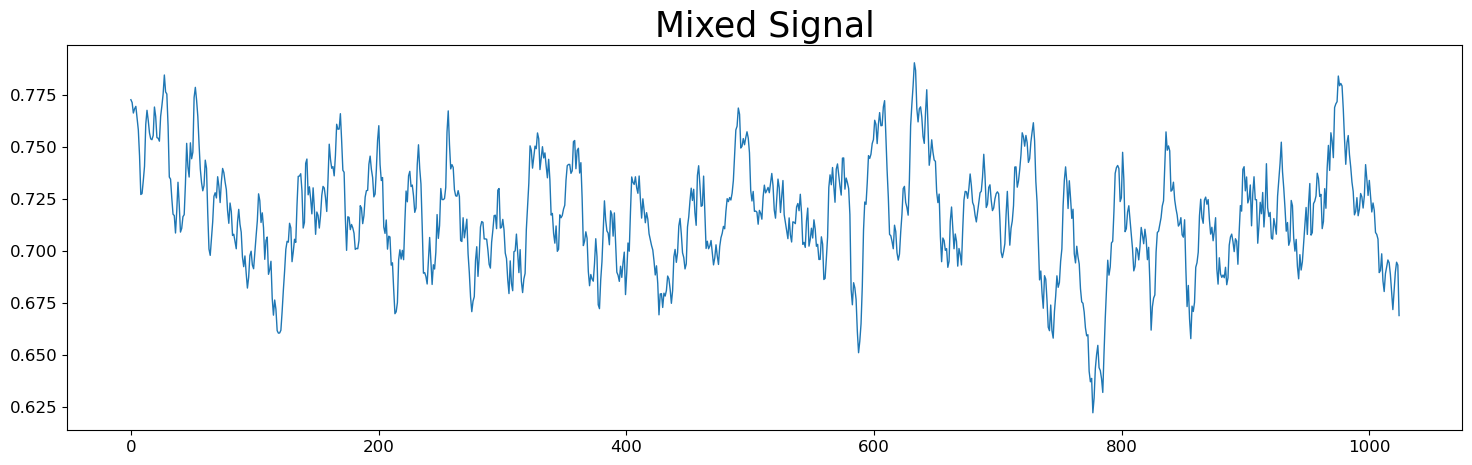

In [21]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],random_matrix.dot(X)[0], lw=1)
ax.set_title('Mixed Signal', fontsize=25)
ax.tick_params(labelsize=12)

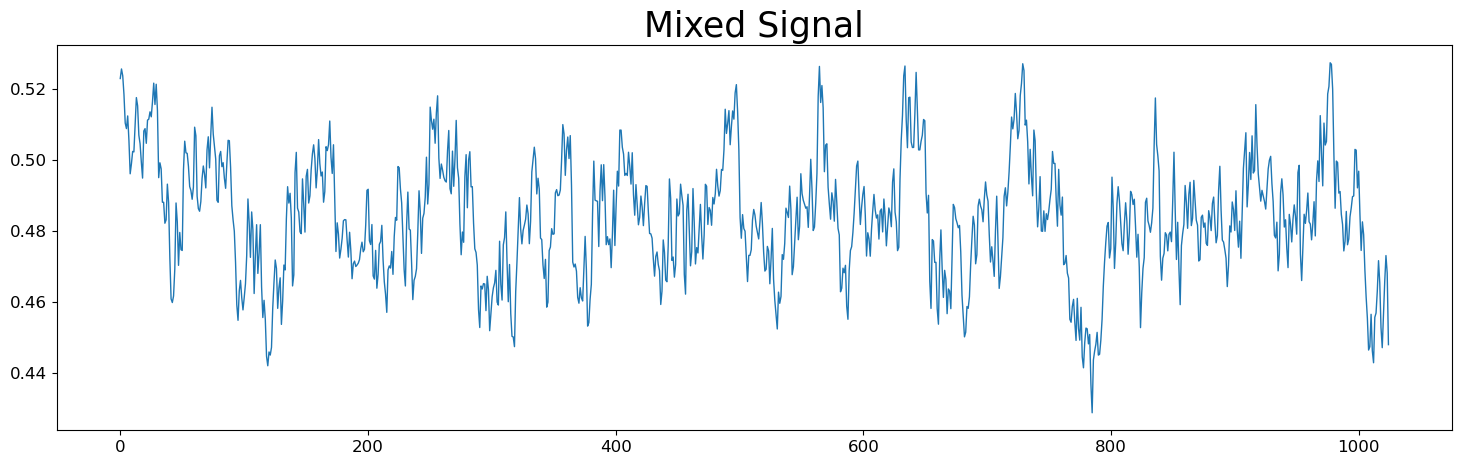

In [22]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],random_matrix.dot(X)[1], lw=1)
ax.set_title('Mixed Signal', fontsize=25)
ax.tick_params(labelsize=12)

In [29]:
opt_sgd = optim.SGD(g_i.parameters(), lr=10)

scaler = torch.cuda.amp.GradScaler()

#for p in model.parameters():
#    p.requires_grad = False
def train_generalized_inverse():
    iteration = 20001
    for i in range(iteration):
        opt_sgd.zero_grad()
        # Evaluate the loss
        signal_x=g_i(y)
        t = torch.randint(0, timesteps, (1,), device="cuda").long()
        loss_diffusion = p_losses(model, signal_x[0][None,None,...], t)
        loss_diffusion2 = p_losses(model, signal_x[1][None,None,...], t)
        loss_diffusion3 = p_losses(model, signal_x[2][None,None,...], t)
        loss_diffusion4 = p_losses(model, signal_x[3][None,None,...], t)
        scaler.scale(loss_diffusion+loss_diffusion2+loss_diffusion3+loss_diffusion4).backward()
        scaler.step(opt_sgd)
        scaler.update()
        if i%1000==0:
            print(f' iteration: {i}, loss: {loss_diffusion.item()+loss_diffusion2.item():g}')
train_generalized_inverse()


 iteration: 0, loss: 0.000118102
 iteration: 1000, loss: 0.00280144
 iteration: 2000, loss: 0.0417155
 iteration: 3000, loss: 0.00566011
 iteration: 4000, loss: 0.0084559
 iteration: 5000, loss: 0.000205261
 iteration: 6000, loss: 0.00142901
 iteration: 7000, loss: 0.0146577
 iteration: 8000, loss: 0.00162984
 iteration: 9000, loss: 0.00334568
 iteration: 10000, loss: 0.000720227
 iteration: 11000, loss: 0.018905
 iteration: 12000, loss: 0.0350701
 iteration: 13000, loss: 0.00610284
 iteration: 14000, loss: 0.00384977
 iteration: 15000, loss: 0.00308024
 iteration: 16000, loss: 7.68216e-05
 iteration: 17000, loss: 0.00015171
 iteration: 18000, loss: 9.24293e-05
 iteration: 19000, loss: 0.000678236
 iteration: 20000, loss: 0.00582887


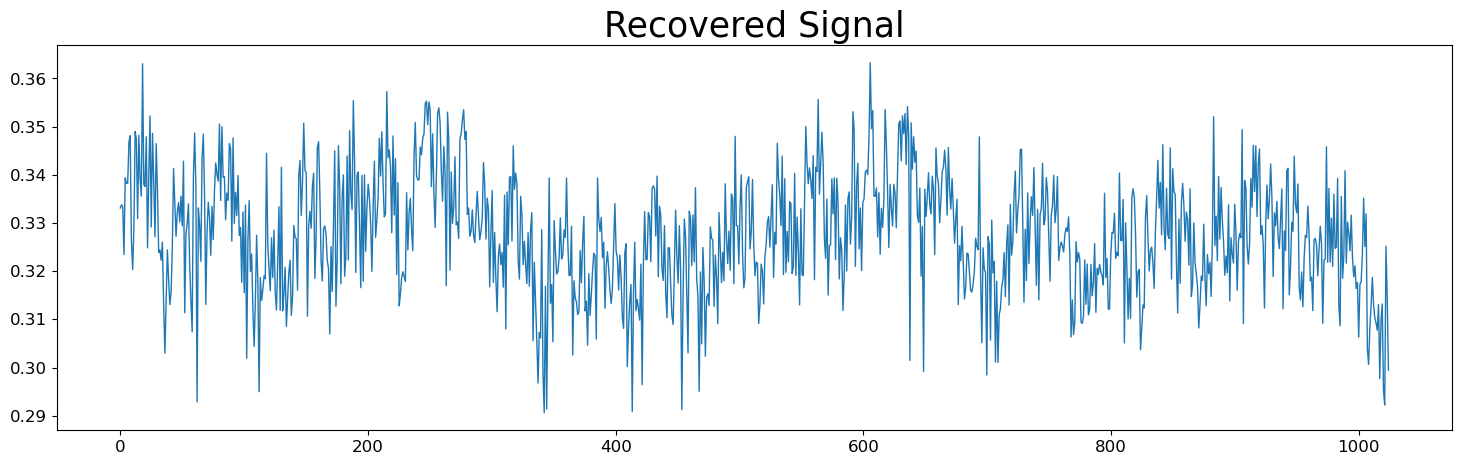

In [30]:
signal_x=g_i(y)
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],signal_x.cpu().detach().numpy()[0,:1024].T, lw=1)
ax.set_title('Recovered Signal', fontsize=25)
ax.tick_params(labelsize=12)

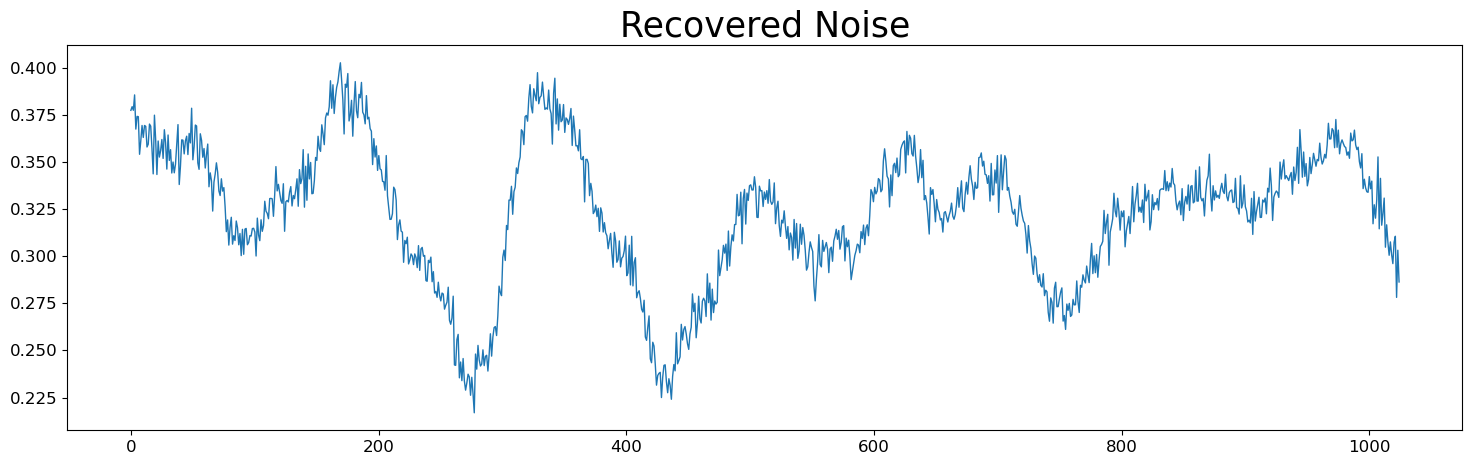

In [31]:
signal_x=g_i(y)
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],signal_x.cpu().detach().numpy()[1,:1024].T, lw=1)
ax.set_title('Recovered Noise', fontsize=25)
ax.tick_params(labelsize=12)

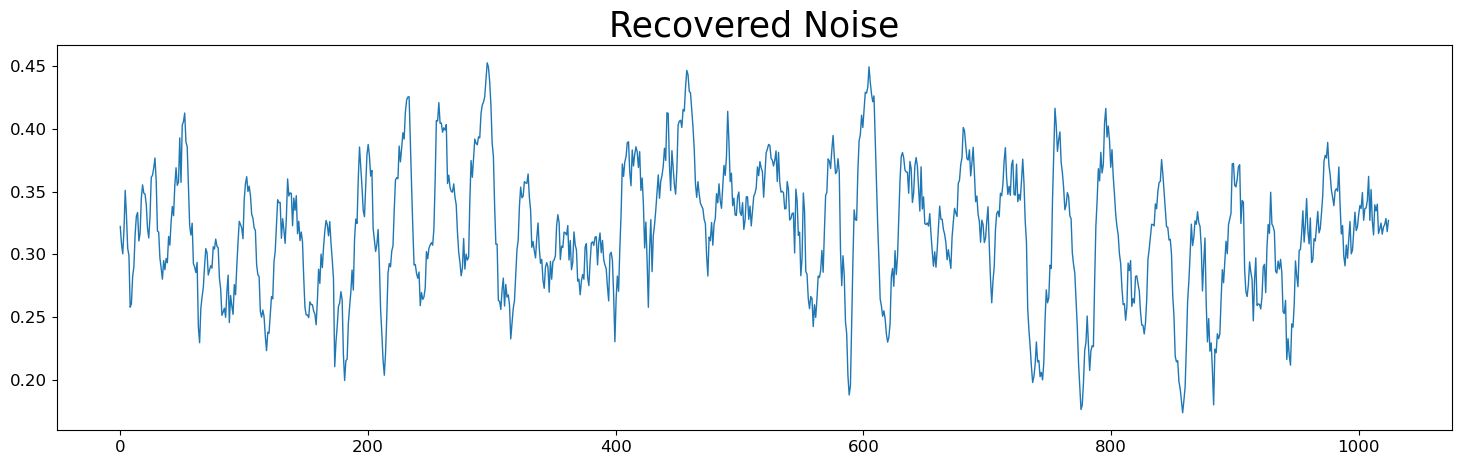

In [32]:
signal_x=g_i(y)
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],signal_x.cpu().detach().numpy()[2,:1024].T, lw=1)
ax.set_title('Recovered Noise', fontsize=25)
ax.tick_params(labelsize=12)

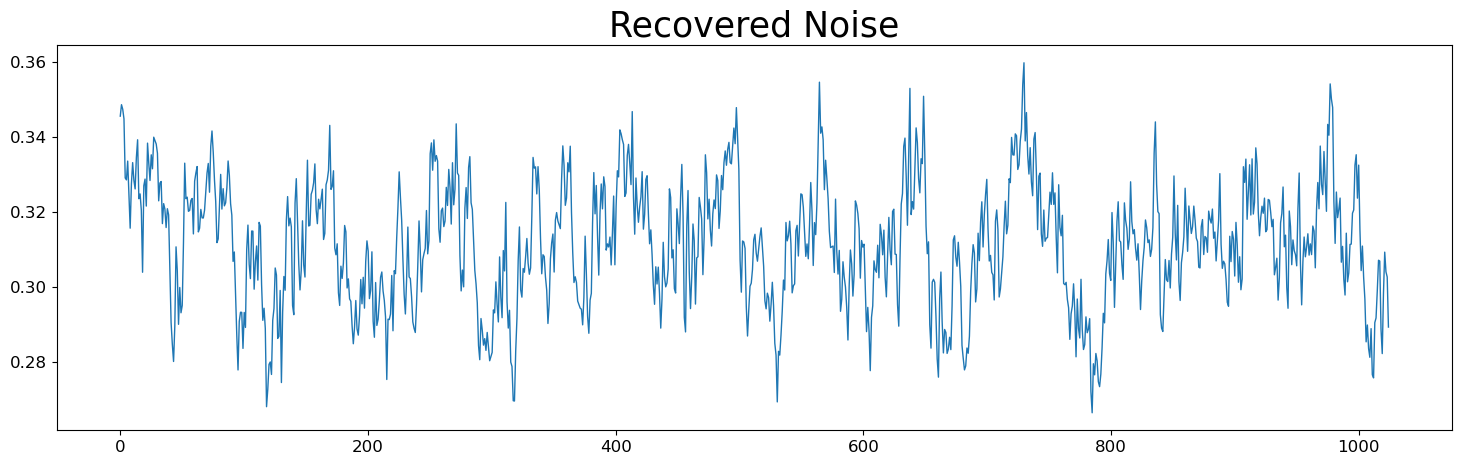

In [33]:
signal_x=g_i(y)
fig, ax = plt.subplots(1, 1, figsize=[18, 5], sharex=True)
ax.plot(ns[:1024],signal_x.cpu().detach().numpy()[3,:1024].T, lw=1)
ax.set_title('Recovered Noise', fontsize=25)
ax.tick_params(labelsize=12)